# Stochastic Gradient Descent

In [3]:
%matplotlib inline
import math
import torch
import d2l

## Stochastic Gradient Updates

Trong học sâu (deep learning), hàm mục tiêu thường là trung bình của các hàm mất mát (loss function) cho từng mẫu trong tập dữ liệu huấn luyện.

Giả sử có một tập huấn luyện gồm $n$ mẫu, gọi $f_i(\mathbf{x})$ là hàm mất mát tương ứng với mẫu huấn luyện thứ $i$, trong đó $\mathbf{x}$ là vector tham số.
Khi đó, ta có hàm mục tiêu:

$$
f(\mathbf{x}) = \frac{1}{n} \sum_{i = 1}^n f_i(\mathbf{x}).
$$

Gradient của hàm mục tiêu tại $\mathbf{x}$ được tính bằng:

$$
\nabla f(\mathbf{x}) = \frac{1}{n} \sum_{i = 1}^n \nabla f_i(\mathbf{x}).
$$

Nếu sử dụng phương pháp **Gradient Descent**, chi phí tính toán cho mỗi vòng lặp cập nhật tham số sẽ là $\mathcal{O}(n)$, tức là **tăng tuyến tính** theo $n$. Do đó, khi tập dữ liệu huấn luyện **càng lớn** thì **chi phí** cho mỗi bước lặp của gradient descent **càng cao**.

Phương pháp **Stochastic Gradient Descent (SGD)** giúp giảm chi phí tính toán ở mỗi bước lặp. Ở mỗi bước của SGD, ta chọn **ngẫu nhiên một mẫu** $i \in \{1, \ldots, n\}$ từ tập dữ liệu, và tính gradient $\nabla f_i(\mathbf{x})$ để cập nhật tham số $\mathbf{x}$:

$$
\mathbf{x} \leftarrow \mathbf{x} - \eta \nabla f_i(\mathbf{x}),
$$

trong đó $\eta$ là tốc độ học (learning rate). Ta thấy rằng chi phí tính toán cho mỗi bước lặp giảm từ $\mathcal{O}(n)$ (của gradient descent) xuống còn hằng số $\mathcal{O}(1)$.

Ngoài ra, cần nhấn mạnh rằng gradient ngẫu nhiên $\nabla f_i(\mathbf{x})$ là một ước lượng không chệch (unbiased estimate) của gradient đầy đủ $\nabla f(\mathbf{x})$ vì:

$$
\mathbb{E}_i \nabla f_i(\mathbf{x}) = \frac{1}{n} \sum_{i = 1}^n \nabla f_i(\mathbf{x}) = \nabla f(\mathbf{x}).
$$

Điều này có nghĩa là, nhìn chung, gradient ngẫu nhiên là một ước lượng tốt cho gradient thực sự.

Bây giờ, chúng ta sẽ so sánh nó với gradient descent bằng cách thêm nhiễu ngẫu nhiên có kỳ vọng bằng 0 và phương sai bằng 1 vào gradient để mô phỏng stochastic gradient descent.

epoch 50, x1: 0.156050, x2: 0.019650


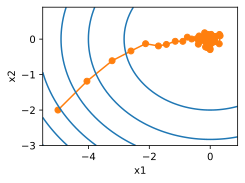

In [7]:
def f(x1, x2):  # Objective function
    return x1 ** 2 + 2 * x2 ** 2

def f_grad(x1, x2):  # Gradient of the objective function
    return 2 * x1, 4 * x2

def sgd(x1, x2, s1, s2, f_grad):
    g1, g2 = f_grad(x1, x2)
    # Simulate noisy gradient
    g1 += torch.normal(0.0, 1, (1,)).item()
    g2 += torch.normal(0.0, 1, (1,)).item()
    eta_t = eta * lr()
    return (x1 - eta_t * g1, x2 - eta_t * g2, 0, 0)

def constant_lr():
    return 1

eta = 0.1
lr = constant_lr  # Constant learning rate
d2l.show_trace_2d(f, d2l.train_2d(sgd, steps=50, f_grad=f_grad))

Như chúng ta có thể thấy, quỹ đạo của các biến trong phương pháp stochastic gradient descent nhiễu hơn nhiều so với quỹ đạo quan sát được trong gradient descent. Điều này là do bản chất ngẫu nhiên của gradient. Cụ thể, ngay cả khi chúng ta đã tiến gần đến điểm cực tiểu, ta vẫn bị ảnh hưởng bởi sự bất định của gradient tức thời $\eta \nabla f_i(\mathbf{x})$. Ngay cả sau 50 bước, chất lượng nghiệm vẫn chưa tốt. Thậm chí tệ hơn, nó sẽ không được cải thiện thêm dù có thực hiện thêm nhiều bước nữa.

Điều này dẫn đến lựa chọn duy nhất: thay đổi tốc độ học $\eta$. Tuy nhiên, nếu chọn giá trị quá nhỏ, ta sẽ không đạt được tiến triển đáng kể ban đầu. Ngược lại, nếu chọn quá lớn, ta sẽ không thu được nghiệm tốt, như đã thấy ở trên. Cách duy nhất để giải quyết mâu thuẫn này là giảm tốc độ học một cách *động* khi quá trình tối ưu hóa tiến triển.

Đây cũng là lý do vì sao cần thêm một hàm tốc độ học `lr` vào hàm cập nhật `sgd`. Trong ví dụ trên, ta đã đặt hàm `lr` tương ứng là hằng số.

## Dynamic Learning Rate

Thay thế $\eta$ bằng một tốc độ học phụ thuộc vào thời gian $\eta(t)$ làm tăng độ phức tạp trong việc kiểm soát sự hội tụ của một thuật toán tối ưu. Cụ thể, chúng ta cần xác định tốc độ giảm của $\eta$. Nếu giảm quá nhanh, quá trình tối ưu sẽ dừng lại quá sớm. Nếu giảm quá chậm, ta sẽ lãng phí quá nhiều thời gian cho việc tối ưu.

Sau đây là một vài chiến lược cơ bản để điều chỉnh $\eta$ theo thời gian:

$$
\begin{aligned}
    \eta(t) & = \eta_i \textrm{ nếu } t_i \leq t \leq t_{i+1}  && \textrm{hằng theo từng khoảng (piecewise constant)} \\
    \eta(t) & = \eta_0 \cdot e^{-\lambda t} && \textrm{giảm theo hàm mũ (exponential decay)} \\
    \eta(t) & = \eta_0 \cdot (\beta t + 1)^{-\alpha} && \textrm{giảm theo đa thức (polynomial decay)}
\end{aligned}
$$

Trong chiến lược *hằng theo từng khoảng*, chúng ta có thể giảm tốc độ học mỗi khi quá trình tối ưu hóa không còn cải thiện. Đây là một chiến lược phổ biến khi huấn luyện các mạng nơ-ron sâu. Ngoài ra, chúng ta có thể giảm mạnh hơn bằng cách *giảm theo hàm mũ*. Tuy nhiên, điều này thường dẫn đến việc dừng tối ưu quá sớm trước khi thuật toán hội tụ.

Một lựa chọn phổ biến là *giảm theo đa thức* với $\alpha = 0.5$. Trong trường hợp tối ưu hóa lồi (convex optimization), có nhiều chứng minh cho thấy tốc độ giảm này hoạt động hiệu quả và ổn định.

Hãy cùng xem việc giảm theo hàm mũ trông như thế nào trong thực tế.

epoch 1000, x1: -0.887758, x2: -0.082764


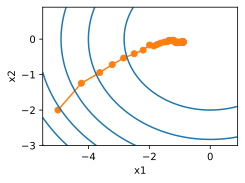

In [6]:
def exponential_lr():
    # Global variable that is defined outside this function and updated inside
    global t
    t += 1
    return math.exp(-0.1 * t)

t = 1
lr = exponential_lr
d2l.show_trace_2d(f, d2l.train_2d(sgd, steps=1000, f_grad=f_grad))

Như dự đoán, phương sai trong các tham số đã giảm đáng kể. Tuy nhiên, điều này phải đánh đổi bằng việc không hội tụ đến nghiệm tối ưu $\mathbf{x} = (0, 0)$. Ngay cả sau 1000 bước lặp, chúng ta vẫn còn rất xa so với nghiệm tối ưu. Thực tế, thuật toán không hội tụ chút nào.

Ngược lại, nếu chúng ta sử dụng phương pháp giảm theo đa thức, trong đó tốc độ học giảm theo nghịch đảo căn bậc hai của số bước, thì khả năng hội tụ được cải thiện rõ rệt chỉ sau 50 bước lặp.

epoch 50, x1: 0.036957, x2: -0.094778


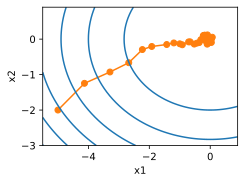

In [8]:
def polynomial_lr():
    # Global variable that is defined outside this function and updated inside
    global t
    t += 1
    return (1 + 0.1 * t) ** (-0.5)

t = 1
lr = polynomial_lr
d2l.show_trace_2d(f, d2l.train_2d(sgd, steps=50, f_grad=f_grad))

Có rất nhiều cách khác nhau để thiết lập tốc độ học. Ví dụ, ta có thể bắt đầu với một tốc độ học nhỏ, sau đó tăng nhanh rồi lại giảm dần, tuy nhiên giảm chậm hơn. Thậm chí, ta có thể xen kẽ giữa tốc độ học nhỏ và lớn. Có rất nhiều chiến lược điều chỉnh tốc độ học như vậy.

## Convergence Analysis for Convex Objectives

Trong phần này, chúng ta sẽ phân tích hội tụ của phương pháp stochastic gradient descent (SGD) đối với hàm mục tiêu lồi tùy chọn.

Giả sử hàm mục tiêu $f(\boldsymbol{\xi}, \mathbf{x})$ là lồi theo $\mathbf{x}$ với mọi mẫu $\boldsymbol{\xi}$. Cụ thể, ta xét công thức cập nhật của SGD:

$$
\mathbf{x}_{t+1} = \mathbf{x}_{t} - \eta_t \partial_\mathbf{x} f(\boldsymbol{\xi}_t, \mathbf{x}),
$$

trong đó $f(\boldsymbol{\xi}_t, \mathbf{x})$ là hàm mục tiêu tương ứng với mẫu huấn luyện $\boldsymbol{\xi}_t$ được lấy ngẫu nhiên tại bước $t$, và $\mathbf{x}$ là tham số mô hình. Gọi:

$$
R(\mathbf{x}) = E_{\boldsymbol{\xi}}[f(\boldsymbol{\xi}, \mathbf{x})]
$$

là rủi ro kỳ vọng, và $R^*$ là giá trị tối thiểu của nó theo $\mathbf{x}$. Gọi $\mathbf{x}^*$ là điểm tối ưu (giả định tồn tại trong miền xác định của $\mathbf{x}$). Khi đó ta có thể theo dõi khoảng cách giữa tham số hiện tại $\mathbf{x}_t$ tại thời điểm $t$ và điểm tối ưu $\mathbf{x}^*$ để xem liệu có cải thiện theo thời gian không:

$$\begin{aligned}    &\|\mathbf{x}_{t+1} - \mathbf{x}^*\|^2 \\ =& \|\mathbf{x}_{t} - \eta_t \partial_\mathbf{x} f(\boldsymbol{\xi}_t, \mathbf{x}) - \mathbf{x}^*\|^2 \\    =& \|\mathbf{x}_{t} - \mathbf{x}^*\|^2 + \eta_t^2 \|\partial_\mathbf{x} f(\boldsymbol{\xi}_t, \mathbf{x})\|^2 - 2 \eta_t    \left\langle \mathbf{x}_t - \mathbf{x}^*, \partial_\mathbf{x} f(\boldsymbol{\xi}_t, \mathbf{x})\right\rangle. \end{aligned} \tag{1} $$

Giả sử chuẩn $\ell_2$ của gradient ngẫu nhiên bị chặn bởi một hằng số $L$, ta có:

$$
\eta_t^2 \|\partial_\mathbf{x} f(\boldsymbol{\xi}_t, \mathbf{x})\|^2 \leq \eta_t^2 L^2. \tag{2}
$$

Chúng ta quan tâm chủ yếu đến việc, trung bình, khoảng cách giữa $\mathbf{x}_t$ và $\mathbf{x}^*$ thay đổi như thế nào. Trên thực tế, khoảng cách này có thể tăng hoặc giảm, tùy thuộc vào mẫu $\boldsymbol{\xi}_t$ mà ta gặp phải. Do đó, ta cần chặn tích vô hướng.

Với mọi hàm lồi $f$, ta có [(first-order condition)](https://machinelearningcoban.com/2017/03/12/convexity/#-first-order-condition):

$$
f(\mathbf{y}) \geq f(\mathbf{x}) + \langle f'(\mathbf{x}), \mathbf{y} - \mathbf{x} \rangle.
$$

Áp dụng với $\mathbf{x}_t$ và $\mathbf{x}^*$, ta được:
<!-- $$\begin{aligned}
 f(\boldsymbol{\xi}_t, \mathbf{x}^*) &\geq f(\boldsymbol{\xi}_t, \mathbf{x}_t) + \left\langle \mathbf{x}^* - \mathbf{x}_t, \partial_{\mathbf{x}} f(\boldsymbol{\xi}_t, \mathbf{x}_t) \right\rangle\\ \left\langle \mathbf{x}^* - \mathbf{x}_t, \partial_{\mathbf{x}} f(\boldsymbol{\xi}_t, \mathbf{x}_t) \right\rangle &\leq f(\boldsymbol{\xi}_t, \mathbf{x}^*) - f(\boldsymbol{\xi}_t, \mathbf{x}_t)\\ - \left\langle \mathbf{x}_t - \mathbf{x}^*, \partial_{\mathbf{x}} f(\boldsymbol{\xi}_t, \mathbf{x}_t) \right\rangle &\leq f(\boldsymbol{\xi}_t, \mathbf{x}^*) - f(\boldsymbol{\xi}_t, \mathbf{x}_t) \label{eq:bat_dang_thuc_first_order_condition} \tag{2}
\end{aligned}$$ -->
$$ f(\boldsymbol{\xi}_t, \mathbf{x}^*) \geq f(\boldsymbol{\xi}_t, \mathbf{x}_t) + \left\langle \mathbf{x}^* - \mathbf{x}_t, \partial_{\mathbf{x}} f(\boldsymbol{\xi}_t, \mathbf{x}_t) \right\rangle $$
$$ \left\langle \mathbf{x}^* - \mathbf{x}_t, \partial_{\mathbf{x}} f(\boldsymbol{\xi}_t, \mathbf{x}_t) \right\rangle \leq f(\boldsymbol{\xi}_t, \mathbf{x}^*) - f(\boldsymbol{\xi}_t, \mathbf{x}_t) $$
$$ - \left\langle \mathbf{x}_t - \mathbf{x}^*, \partial_{\mathbf{x}} f(\boldsymbol{\xi}_t, \mathbf{x}_t) \right\rangle \leq f(\boldsymbol{\xi}_t, \mathbf{x}^*) - f(\boldsymbol{\xi}_t, \mathbf{x}_t) \tag{3} $$
Thay hai bất đẳng thức $(2)$ và $(3)$ vào biểu thức $(1)$, ta thu được:

$$
\begin{aligned}
\|\mathbf{x}_{t+1} - \mathbf{x}^*\|^2 &\leq \|\mathbf{x}_{t} - \mathbf{x}^*\|^2 + \eta_t^2 L^2 - 2 \eta_t (f(\boldsymbol{\xi}_t, \mathbf{x}^*) - f(\boldsymbol{\xi}_t, \mathbf{x}_t))\\
\|\mathbf{x}_{t} - \mathbf{x}^*\|^2 - \|\mathbf{x}_{t+1} - \mathbf{x}^*\|^2 &\geq 2 \eta_t (f(\boldsymbol{\xi}_t, \mathbf{x}_t) - f(\boldsymbol{\xi}_t, \mathbf{x}^*)) - \eta_t^2 L^2.
\end{aligned}
$$

Điều này có nghĩa là ta đang tiến gần đến điểm tối ưu miễn là sự khác biệt giữa giá trị mất mát (loss) hiện tại và giá trị mất mát tối ưu lớn hơn $\eta_t L^2 / 2$. Do sự khác biệt này sẽ tiến dần về 0 nên tốc độ học $\eta_t$ cũng cần *giảm dần*.

Tiếp theo, lấy kỳ vọng của bất đẳng thức trên:

$$
E\left[\|\mathbf{x}_{t} - \mathbf{x}^*\|^2\right] - E\left[\|\mathbf{x}_{t+1} - \mathbf{x}^*\|^2\right] \geq 2 \eta_t [E[R(\mathbf{x}_t)] - R^*] -  \eta_t^2 L^2.
$$

Tổng các bất đẳng thức này với $t = 1, \ldots, T$, và bỏ đi phần âm, ta được:

$$
\|\mathbf{x}_1 - \mathbf{x}^*\|^2 \geq 2 \left (\sum_{t=1}^T   \eta_t \right) [E[R(\mathbf{x}_t)] - R^*] - L^2 \sum_{t=1}^T \eta_t^2.
$$

Do $\mathbf{x}_1$ là giá trị đã biết nên ta bỏ kỳ vọng. Định nghĩa:

$$
\bar{\mathbf{x}} := \frac{\sum_{t=1}^T \eta_t \mathbf{x}_t}{\sum_{t=1}^T \eta_t}.
$$

Ta có:

$$
E\left(\frac{\sum_{t=1}^T \eta_t R(\mathbf{x}_t)}{\sum_{t=1}^T \eta_t}\right) = \frac{\sum_{t=1}^T \eta_t E[R(\mathbf{x}_t)]}{\sum_{t=1}^T \eta_t} = E[R(\mathbf{x}_t)].
$$

Do bất đẳng thức Jensen và tính lồi của $R$, ta có:

$$
E[R(\mathbf{x}_t)] \geq E[R(\bar{\mathbf{x}})],
\Rightarrow \sum_{t=1}^T \eta_t E[R(\mathbf{x}_t)] \geq \sum_{t=1}^T \eta_t  E\left[R(\bar{\mathbf{x}})\right].
$$

Thay vào bất đẳng thức trên, ta được:

$$
\left[E[R(\bar{\mathbf{x}})]\right] - R^* \leq \frac{r^2 + L^2 \sum_{t=1}^T \eta_t^2}{2 \sum_{t=1}^T \eta_t},
$$

với $r^2 := \|\mathbf{x}_1 - \mathbf{x}^*\|^2$ là độ chênh lệch giữa điểm khởi đầu và điểm tối ưu. Tóm lại, tốc độ hội tụ phụ thuộc vào việc gradient ngẫu nhiên được chặn như thế nào ($L$) và điểm bắt đầu cách xa tối ưu bao nhiêu ($r$).

Khi $r, L$, và $T$ đã biết, ta có thể chọn tốc độ học $\eta = r/(L \sqrt{T})$. Khi đó, ta có chặn trên là $rL/\sqrt{T}$, tức ta hội tụ với tốc độ $\mathcal{O}(1/\sqrt{T})$ đến nghiệm tối ưu.

## Stochastic Gradients and Finite Samples

Cho đến giờ, chúng ta đã nói về **stochastic gradient descent (SGD)** một cách khá đơn giản và sơ lược. Chúng ta giả định rằng ta lấy các mẫu $x_i$, thường đi kèm với nhãn $y_i$, từ một phân phối nào đó $p(x, y)$ và sử dụng chúng để cập nhật các tham số của mô hình theo một cách nào đó. Cụ thể hơn, với một tập dữ liệu hữu hạn, ta đã lập luận rằng phân phối rời rạc $p(x, y) = \frac{1}{n} \sum_{i=1}^n \delta_{x_i}(x) \delta_{y_i}(y)$
với một số hàm $\delta_{x_i}$ và $\delta_{y_i}$
cho phép ta thực hiện SGD trên phân phối đó.

Tuy nhiên, thực tế không hoàn toàn như vậy. Trong các ví dụ minh họa đơn giản ở phần này, ta đơn giản chỉ thêm nhiễu vào gradient không ngẫu nhiên, tức là ta giả vờ như đang có các cặp $(x_i, y_i)$. Điều này là hợp lý trong ngữ cảnh ở đây (xem bài tập để hiểu chi tiết hơn). Điều đáng lo ngại hơn là trong các phần trước, rõ ràng ta không làm như vậy. Thay vào đó, ta **duyệt qua tất cả các mẫu huấn luyện đúng một lần**. Để thấy tại sao cách làm này tốt hơn, hãy xét tình huống ngược lại: giả sử ta chọn ngẫu nhiên $n$ quan sát từ phân phối rời rạc **có hoàn lại**. Xác suất để chọn một phần tử $i$ bất kỳ là $1/n$. Do đó, xác suất để **chọn được ít nhất một lần** là:

$P(\textrm{chọn~} i) = 1 - P(\textrm{không chọn~} i) = 1 - (1-1/n)^n \approx 1-e^{-1} \approx 0.63.$

Lập luận tương tự cho thấy xác suất chọn một mẫu **chính xác một lần duy nhất** là:

${n \choose 1} \frac{1}{n} \left(1-\frac{1}{n}\right)^{n-1} = \frac{n}{n-1} \left(1-\frac{1}{n}\right)^{n} \approx e^{-1} \approx 0.37.$

Việc lấy mẫu **có hoàn lại** làm tăng phương sai và giảm hiệu quả sử dụng dữ liệu so với lấy mẫu **không hoàn lại**. Do đó, trong thực tế, ta thường dùng cách lấy mẫu **không hoàn lại** (và đây cũng là cách được mặc định sử dụng xuyên suốt trong cuốn sách này). Cuối cùng, lưu ý rằng nếu duyệt lại tập huấn luyện nhiều lần thì mỗi lần như vậy sẽ duyệt qua tập dữ liệu theo **một thứ tự ngẫu nhiên khác nhau**.

## Exercises

### Exercise 1

Experiment with different learning rate schedules for stochastic gradient descent and with different numbers of iterations. In particular, plot the distance from the optimal solution $(0, 0)$ as a function of the number of iterations.

epoch 50, x1: 0.168584, x2: -0.005244


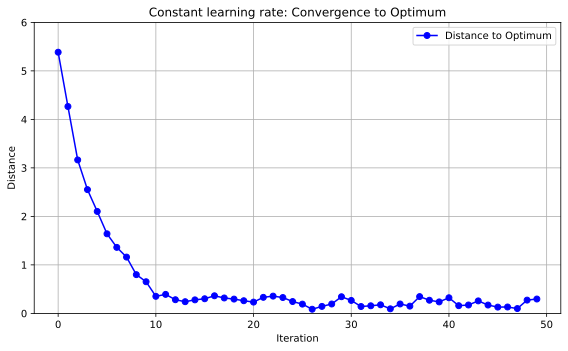

epoch 50, x1: -0.891282, x2: -0.009391


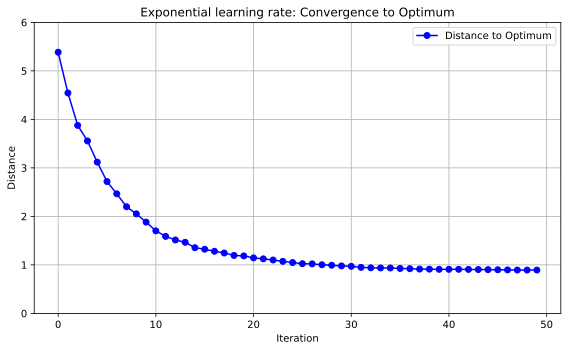

epoch 50, x1: 0.032737, x2: -0.080953


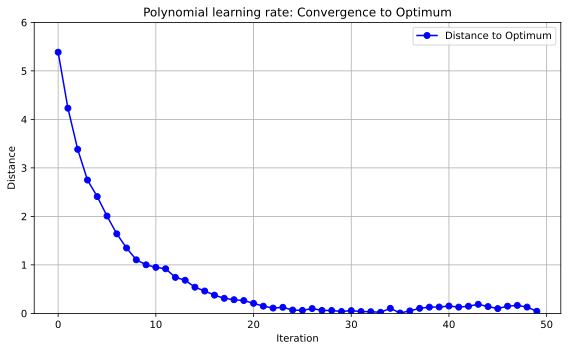

In [ ]:
def sgd(x1, x2, s1, s2, f_grad):
    dist_to_optimum.append(d2l.np.linalg.norm([x1, x2]).item())
    g1, g2 = f_grad(x1, x2)
    # Simulate noisy gradient
    g1 += torch.normal(0.0, 1, (1,)).item()
    g2 += torch.normal(0.0, 1, (1,)).item()
    eta_t = eta * lr()
    return (x1 - eta_t * g1, x2 - eta_t * g2, 0, 0)

# CONSTANT LEARNING RATE
dist_to_optimum = []
eta = 0.1
lr = constant_lr  # Constant learning rate
d2l.train_2d(sgd, steps=50, f_grad=f_grad)

# Plotting
d2l.plt.figure(figsize=(8, 5))
d2l.plt.plot(dist_to_optimum, marker='o', linestyle='-', color='blue', label='Distance to Optimum')
d2l.plt.xlabel('Iteration')
d2l.plt.ylabel('Distance')
d2l.plt.title('Constant learning rate: Convergence to Optimum')
d2l.plt.ylim(0, 6)
d2l.plt.grid(True)
d2l.plt.legend()
d2l.plt.tight_layout()
d2l.plt.show()

# EXPONENTIAL LEARNING RATE
dist_to_optimum = []
t = 1
lr = exponential_lr
d2l.train_2d(sgd, steps=50, f_grad=f_grad)

# Plotting
d2l.plt.figure(figsize=(8, 5))
d2l.plt.plot(dist_to_optimum, marker='o', linestyle='-', color='blue', label='Distance to Optimum')
d2l.plt.xlabel('Iteration')
d2l.plt.ylabel('Distance')
d2l.plt.title('Exponential learning rate: Convergence to Optimum')
d2l.plt.ylim(0, 6)
d2l.plt.grid(True)
d2l.plt.legend()
d2l.plt.tight_layout()
d2l.plt.show()

# POLYNOMIAL LEARNING RATE
dist_to_optimum = []
t = 1
lr = polynomial_lr
d2l.train_2d(sgd, steps=50, f_grad=f_grad)

# Plotting
d2l.plt.figure(figsize=(8, 5))
d2l.plt.plot(dist_to_optimum, marker='o', linestyle='-', color='blue', label='Distance to Optimum')
d2l.plt.xlabel('Iteration')
d2l.plt.ylabel('Distance')
d2l.plt.title('Polynomial learning rate: Convergence to Optimum')
d2l.plt.ylim(0, 6)
d2l.plt.grid(True)
d2l.plt.legend()
d2l.plt.tight_layout()
d2l.plt.show()

### Exercise 2

Prove that for the function $f(x_1, x_2) = x_1^2 + 2 x_2^2$ adding normal noise to the gradient is equivalent to minimizing a loss function $f(\mathbf{x}, \mathbf{w}) = (x_1 - w_1)^2 + 2 (x_2 - w_2)^2$ where $\mathbf{x}$ is drawn from a normal distribution.

Ta có gradient của hàm f(x1,x2):
$$ \nabla f(x_1, x_2) = \begin{bmatrix} 2x_1 \\ 4x_2 \end{bmatrix} (1) $$

gradient sau khi được thêm nhiễu:
$\tilde{\nabla} f(x) = \nabla f(x) + \epsilon, \quad \epsilon \sim \mathcal{N}(0, \sigma^2 I)$

Thưc hiện lấy gradient của hàm f(x,w):
Ta có 
$$
\nabla_{\mathbf{w}} L(\mathbf{w}) = \begin{bmatrix} \frac{\partial}{\partial w_1} (x_1 - w_1)^2 \\ \frac{\partial}{\partial w_2} 2(x_2 - w_2)^2 \end{bmatrix}
=  \begin{bmatrix} -2(x_1 - w_1) \\ -4(x_2 - w_2) \end{bmatrix} 
$$

Thực hiên lấy kỳ vọng của công thức trên ta có:
$$ \nabla_{\mathbf{w}} L(\mathbf{w}) = \mathbb{E} \left[ \begin{bmatrix} -2(x_1 - w_1) \\ -4(x_2 - w_2) \end{bmatrix} \right] $$ 

Tương đương 
$$ \begin{bmatrix} -2(\mathbb{E} \left[x_1\right] - w_1) \\ -4(\mathbb{E} \left[x_2\right] - w_2) \end{bmatrix} $$ 

Vì x có phân phối chuẩn $\mathbf{x} \sim \mathcal{N}(0, I)$ và x1 và x2 là hai giá trị ngẫu nhiên nên $\mathbb{E} \left[x_1\right] =  \left[x_2\right] = 0$:
$$ \nabla_{\mathbf{w}} L(\mathbf{w}) = \begin{bmatrix} 2(w_1) \\ 4( w_2) \end{bmatrix} (2) $$ 
Từ (1) và (2) có thể thấy hàm $f(x1,x2)$ = $x_1^2 + x_2^2$ có thêm nhiễu vào gradient có thể tương đương với gradient của hàm $f(x,w) = (x_1-w_1)^2 +2*(x_2-w_2)^2$ dùng để cập nhật tham số và tìm điểm cực tiểu của hàm.  

In [ ]:
#Define function for f(x1,x2) 
def f1(x1,x2):
    return x1**2 + 2*x2**2

# Define gradient of f(x1,x2)
def f1_grad(x1,x2):
    return 2*x1, 4*x2 

# Define gradient of f(x,w)
def f2(x,w):
    return (x[0] - w[0])**2 + 2*(x[1] - w[1])**2

# Define gradient of f(x,w)
def f2_grad(x,w):
    return -2*(x[0] - w[0]), -4*(x[1] - w[1])

g_f1= []
# Gradient computing and weight updating for f(x1,x2)
def sgd_f1(x1, x2, s1, s2, f1_grad):
    g1, g2 = f1_grad(x1, x2)
    # Simulate noisy gradient
    g1 += torch.normal(0.0, 1, (1,)).item() #Add normal noise
    g2 += torch.normal(0.0, 1, (1,)).item() #Add normal noise
    g_f1.append(torch.tensor([g1,g2]))
    eta_t = eta * lr()
    return (x1 - eta_t * g1, x2 - eta_t * g2, 0, 0)

noise_std = 1.0
g_f2= []
x_sample = []
# Gradient computing and weight updating for f(x,w)
def sgd_f2(x1, x2, s1, s2, f2_grad):
    x= torch.randn(2)
    x_sample.append(x)
    w = torch.tensor([x1,x2])
    g1, g2 = f2_grad(x, w)
    g_f2.append(torch.tensor([g1,g2]))
    eta_t = eta * lr()
    return (x1 - eta_t * g1, x2 - eta_t * g2, 0, 0)


eta = 0.1
lr = polynomial_lr  # Constant learning rate
result_f1 = d2l.train_2d(sgd_f1, steps=1000, f_grad=f1_grad)
result_f2 = d2l.train_2d(sgd_f2, steps=1000, f_grad=f2_grad)
print("Average gradient for f(x1,x2) when adding noise gradient:", torch.stack(g_f1).mean(dim=0))
print("Average gradient for f(x,w)",torch.stack(g_f2).mean(dim=0))




epoch 1000, x1: -0.297215, x2: -0.019080
epoch 1000, x1: -0.351130, x2: -0.073881
Average gradient for f(x1,x2) when adding noise gradient: tensor([-3.3104, -1.3927])
Average gradient for f(x,w) tensor([-3.3052, -1.3673])


### Exercise 3

Compare convergence of stochastic gradient descent when you sample from $\{(x_1, y_1), \ldots, (x_n, y_n)\}$ with replacement and when you sample without replacement.

epoch 199, x1: -0.128043, x2: -0.121439


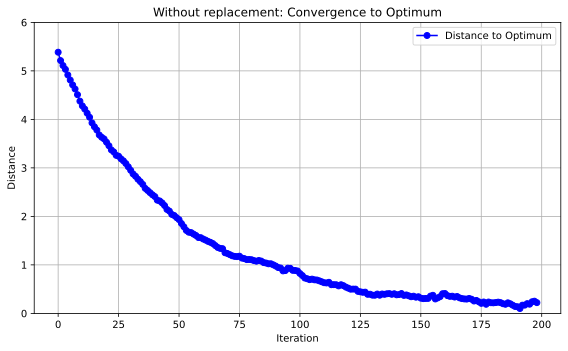

epoch 199, x1: -0.119933, x2: -0.130599


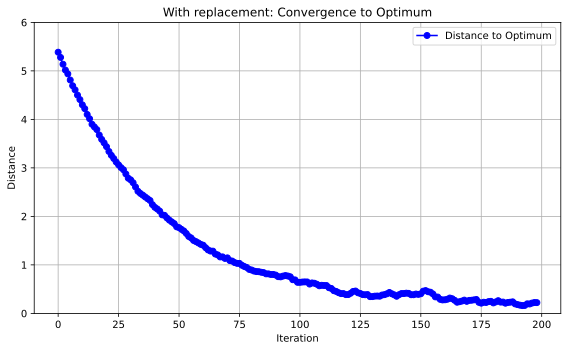

In [130]:
import random


def show_trace_2d_custom(x_subsample, results, color, label):
    """Show the trace of 2D variables during optimization.

    Defined in :numref:`subsec_gd-learningrate`"""
    d2l.set_figsize()
    d2l.plt.plot(*zip(*results), '-o', color=color, label=label)
    x1, x2 = d2l.meshgrid(d2l.arange(-5.5, 1.0, 0.1),
                          d2l.arange(-3.0, 1.0, 0.1), indexing='ij')
    w = [x1,x2]
    d2l.plt.contour(x1, x2, f_ex3(x_subsample, w), colors='#1f77b4')
    d2l.plt.xlabel('x1')
    d2l.plt.ylabel('x2')
    d2l.plt.legend()

x_sample = torch.randn(200,2)
x_choices = [x_sample[0]]
x_subsample=[x_sample[0]]
eta = 0.01
t = 1

# Define gradient of f(x,w)
def f_ex3(x,w):
    return (x[0] - w[0])**2 + 2*(x[1] - w[1])**2

# Define gradient of f(x,w)
def f_ex3_grad(x,w):
    return -2*(x[0] - w[0]), -4*(x[1] - w[1])


def sgd_replacement(x1, x2, s1, s2, f2_grad):
    dist_to_optimum.append(d2l.np.linalg.norm([x1, x2]).item())
    x= random.choice(x_sample)
    x_choices.append(x)
    w = torch.tensor([x1,x2])
    g1, g2 = f2_grad(x, w)
    eta_t = eta * lr()
    return (x1 - eta_t * g1, x2 - eta_t * g2, 0, 0)

i=0
def sgd_without_replacement(x1, x2, s1, s2, f2_grad):
    global i 
    i += 1
    x = x_sample[i]
    x_subsample.append(x)
    dist_to_optimum.append(d2l.np.linalg.norm([x1, x2]).item())
    w = torch.tensor([x1,x2])
    g1, g2 = f2_grad(x, w)
    eta_t = eta * lr()
    return (x1 - eta_t * g1, x2 - eta_t * g2, 0, 0)


# show_trace_2d_custom(x_subsample[-1], d2l.train_2d(sgd_without_replacement, steps=999, f_grad=f_ex3_grad),"#0000ff", "Without replacement")
# show_trace_2d_custom(x_choices[-1], d2l.train_2d(sgd_replacement, steps=999, f_grad=f_ex3_grad),"#ff7f0e","With replacement")
dist_to_optimum=[]
d2l.train_2d(sgd_without_replacement, steps=199, f_grad=f_ex3_grad)
d2l.plt.figure(figsize=(8, 5))
d2l.plt.plot(dist_to_optimum, marker='o', linestyle='-', color='blue', label='Distance to Optimum')
d2l.plt.xlabel('Iteration')
d2l.plt.ylabel('Distance')
d2l.plt.title('Without replacement: Convergence to Optimum')
d2l.plt.ylim(0, 6)
d2l.plt.grid(True)
d2l.plt.legend()
d2l.plt.tight_layout()
d2l.plt.show()

dist_to_optimum=[]
d2l.train_2d(sgd_replacement, steps=199, f_grad=f_ex3_grad)
d2l.plt.figure(figsize=(8, 5))
d2l.plt.plot(dist_to_optimum, marker='o', linestyle='-', color='blue', label='Distance to Optimum')
d2l.plt.xlabel('Iteration')
d2l.plt.ylabel('Distance')
d2l.plt.title('With replacement: Convergence to Optimum')
d2l.plt.ylim(0, 6)
d2l.plt.grid(True)
d2l.plt.legend()
d2l.plt.tight_layout()
d2l.plt.show()




### Exercise 4

How would you change the stochastic gradient descent solver if some gradient (or rather some coordinate associated with it) was consistently larger than all the other gradients?

Trong quá trình tối ưu bằng Stochastic Gradient Descent (SGD), nếu một thành phần (tọa độ) của gradient luôn có giá trị lớn hơn đáng kể so với các thành phần còn lại, điều này có thể khiến việc cập nhật tham số bị lệch, dẫn đến quá trình hội tụ trở nên **kém hiệu quả** hoặc thậm chí **không ổn định**.

Để khắc phục vấn đề này, ta có thể áp dụng một trong hai giải pháp sau:

1. **Điều chỉnh tốc độ học theo từng tọa độ**:
   Giảm tốc độ học (learning rate) cho các tọa độ có gradient lớn hơn nhằm hạn chế việc cập nhật quá mạnh ở các chiều đó, giúp quá trình tối ưu trở nên cân bằng và ổn định hơn.
1. **Gradient clipping** (cắt gradient):
   Giới hạn độ lớn tối đa của gradient, bằng cách cắt ngắn (rescale) vector gradient nếu nó vượt quá một ngưỡng cho trước. Điều này giúp tránh việc các gradient cực lớn gây ra những bước nhảy quá lớn trong quá trình cập nhật tham số.

### Exercise 5

Assume that $f(x) = x^2 (1 + \sin x)$. How many local minima does $f$ have? Can you change $f$ in such a way that to minimize it one needs to evaluate all the local minima?